# Sensitivity Analysis

In [1]:
import os
import itertools
import random

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sys
sys.path.insert(0, '../utils')
import model_utils
import geoutils

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

SEED = 42

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
output_dir = "../outputs/"
results_10k_dir = output_dir + '10k_results/'
results_30k_dir = output_dir + '30k_results/'
results_50k_dir = output_dir + '50k_results/'

## Load Logistic Regression Results

In [10]:
models, labels = model_utils.get_hyperparameters(model='random_forest')
rf_10k_results = model_utils.load_results(labels, results_10k_dir, model_prefix='random_forest')
rf_30k_results = model_utils.load_results(labels, results_30k_dir, model_prefix='random_forest')
rf_50k_results = model_utils.load_results(labels, results_50k_dir, model_prefix='random_forest')

rf_30k_results['pixel_preds'][index].head(3)

,grid_id,area,y_pred,y_test
0,62,0,0.007920,0
1,64,0,0.005462,0
2,60,0,0.010227,0


## Load Predictions per Municipality

In [15]:
rf_10k_results_per_area = model_utils.evaluate_model_per_area(rf_10k_results)
rf_30k_results_per_area = model_utils.evaluate_model_per_area(rf_30k_results)
rf_50k_results_per_area = model_utils.evaluate_model_per_area(rf_50k_results)

rf_50k_results_per_area[0]['grid_preds'][index].head(3)

,grid_id,area,y_pred,y_test
grid_id,,,,
1,1,0,0.922670,1
2,2,0,0.885714,1
3,3,0,0.871081,1


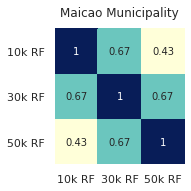

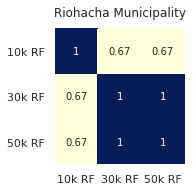

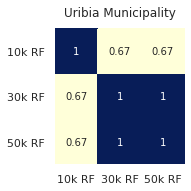

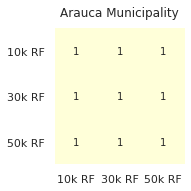

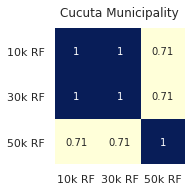

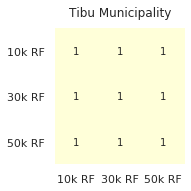

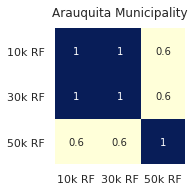

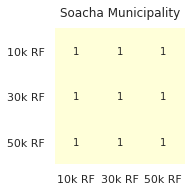

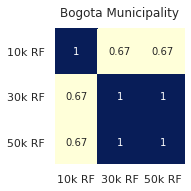

In [122]:
results_dict = {
    '10k RF' : rf_10k_results_per_area,
    '30k RF' : rf_30k_results_per_area,
    '50k RF' : rf_50k_results_per_area,
}

model_utils.generate_iou_matrix(results_dict, index, percent=0.10)